### Data Dictionary

In the US, probation and parole officers along with judges are often using algorithms to assess a criminal defendant's likelihood to re-offend (called recidivism). One of the leading tools to do this is the COMPAS algorithm, which stands for “Correctional Offender Management Profiling for Alternative Sanctions.”

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("compasviolent.csv",parse_dates=['compas_screening_date','dob','c_jail_in','c_jail_out'])

In [3]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:00,2013-08-14 05:41:00,13011352CF10A,13/8/2013,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,14/8/2013,Risk of Violence,1,Low,14/8/2013,7/7/2014,14/7/2014,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:00,2013-05-02 05:36:00,13001275CF10A,26/1/2013,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,5/7/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),5/7/2013,Felony Battery (Dom Strang),Risk of Recidivism,Low,27/1/2013,Risk of Violence,1,Low,27/1/2013,26/1/2013,5/2/2013,9,159,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaT,NaT,13000570CF10A,12/1/2013,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,High,13/1/2013,Risk of Violence,6,Medium,13/1/2013,NaN,NaN,0,1174,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaT,NaT,12014130CF10A,NaN,9/1/2013,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,26/3/2013,Risk of Violence,1,Low,26/3/2013,NaN,NaN,0,1102,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:00,2013-01-12 12:28:00,13022355MM10A,30/11/2013,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,30/11/2013,Risk of Violence,1,Low,30/11/2013,30/11/2013,1/12/2013,1,853,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,0,9,0,0,0,-1.0,2013-10-19 11:17:00,2013-10-20 08:13:00,13014650CF10A,19/10/2013,NaN,1.0,F,Possession of Cocaine,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,High,20/10/2013,Risk of Violence,9,High,20/10/2013,7/4/2014,27/4/2014,0,169,0,0
4739,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:00,2013-11-24 02:59:00,13016249CF10A,22/11/2013,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Medium,23/11/2013,Risk of Violence,5,Medium,23/11/2013,22/11/2013,24/11/2013,1,860,0,0
4740,10997,malcolm simmons,malcolm,simmons,2014-01-02,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:00,2014-02-02 04:03:00,14001422CF10A,31/1/2014,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,1/2/2014,Risk of Violence,5,Medium,1/2/2014,31/1/2014,2/2/2014,1,790,0,0
4741,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-01-10,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:00,2014-01-14 07:49:00,14000581CF10A,13/1/2014,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,14/1/2014,Risk of Violence,1,Low,14/1/2014,13/1/201

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       4743 non-null   int64         
 1   name                     4743 non-null   object        
 2   first                    4743 non-null   object        
 3   last                     4743 non-null   object        
 4   compas_screening_date    4743 non-null   datetime64[ns]
 5   sex                      4743 non-null   object        
 6   dob                      4743 non-null   datetime64[ns]
 7   age                      4743 non-null   int64         
 8   age_cat                  4743 non-null   object        
 9   race                     4743 non-null   object        
 10  juv_fel_count            4743 non-null   int64         
 11  decile_score             4743 non-null   int64         
 12  juv_misd_count           4743 non-

In [5]:
df.describe(include='all')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,start,end,event,two_year_recid
count,4743.000000,4743,4743,4743,4743,4743,4743,4743.000000,4743,4743,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4475.000000,4475,4475,4732,3972,760,4732.000000,4743,4726,4743.000000,995,995,690.000000,995,972,690,690,0.0,4743.000000,819,819,819,819,4743,4738,4743,4743,4743.000000,4743,4743,4534,4534,4743.000000,4743.000000,4743.000000,4743.000000
unique,NaN,4721,2114,2897,586,2,3978,NaN,3,6,NaN,NaN,NaN,NaN,NaN,NaN,4446,4097,4732,766,425,NaN,2,362,NaN,995,10,NaN,675,196,522,494,NaN,NaN,819,9,570,83,1,3,586,1,NaN,3,586,1003,1012,NaN,NaN,NaN,NaN
top,NaN,steven wilson,michael,williams,2013-09-23 00:00:00,Male,1991-08-10 00:00:00,NaN,25 - 45,African-American,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 07:47:00,2014-11-02 08:51:00,13009762CF10A,14/1/2013,15/5/2013,NaN,F,Battery,NaN,16003477CF10A,(M1),NaN,1/3/2016,Battery,18/2/2014,13/11/2013,NaN,NaN,15013027MM10A,(M1),15/8/2015,Battery,Risk of Recidivism,Low,23/9/2013,Risk of Violence,NaN,Low,23/9/2013,4/1/2014,1/1/2020,NaN,NaN,NaN,NaN
freq,NaN,2,95,49,24,3746,4,NaN,2699,2266,NaN,NaN,NaN,NaN,NaN,NaN,2,4,1,21,7,NaN,2880,886,NaN,1,423,NaN,5,192,5,5,NaN,NaN,1,344,6,329,4743,2939,24,4743,NaN,3389,24,19,27,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,2013-01-01 00:00:00,NaN,1932-09-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01 03:16:00,2013-01-02 01:46:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2014-12-31 00:00:00,NaN,1998-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-02 05:28:00,2016-04-03 08:51:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5454.230445,NaN,NaN,NaN,NaN,NaN,NaN,36.002952,NaN,NaN,0.045330,3.978073,0.070841,0.080751,2.677209,2.723799,NaN,NaN,NaN,NaN,NaN,72.691251,NaN,NaN,0.209783,NaN,NaN,8.918841,NaN,NaN,NaN,NaN,NaN,0.172676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.338815,NaN,NaN,NaN,NaN,9.084124,730.143369,0.165507,0.163399
std,3189.515451,NaN,NaN,NaN,NaN,NaN,NaN,12.200715,NaN,NaN,0.420694,2.749706,0.406142,0.468779,4.084277,78.074361,NaN,NaN,NaN,NaN,NaN,385.694476,NaN,NaN,0.407196,NaN,NaN,40.179739,NaN,NaN,NaN,NaN,NaN,0.378006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.415791,NaN,NaN,NaN,NaN,36.867544,365.435158,0.371677,0.369768
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,NaN,0.000000,-1.000000,0.000000,0.000000,0.000000,-345.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000
25%,2631.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,422.500000,0.000000,0.000000


In [6]:
df.shape

(4743, 51)

In [7]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text',
       'screening_date', 'v_type_of_assessment', 'v_decile_score',
       'v_score_text', 'v_screening_date', 'in_custody', 'out_custody',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

How many observations are in this table? Answer: 4743 obs

How many variables in this table? Answer: 53

Which variables appear to be from collected data? Ans: Name, compas_screening_date, sex, dob, race

Which variables appear to be assigned by the user? Ans: First, Last, Age_Cat, c_case_number

Which variables appear to generated by algorithms? Ans: priors_count.1, decile_score.1, v_score_text, two_year_recid1

### Data Visualization

### Univariate Data Exploration

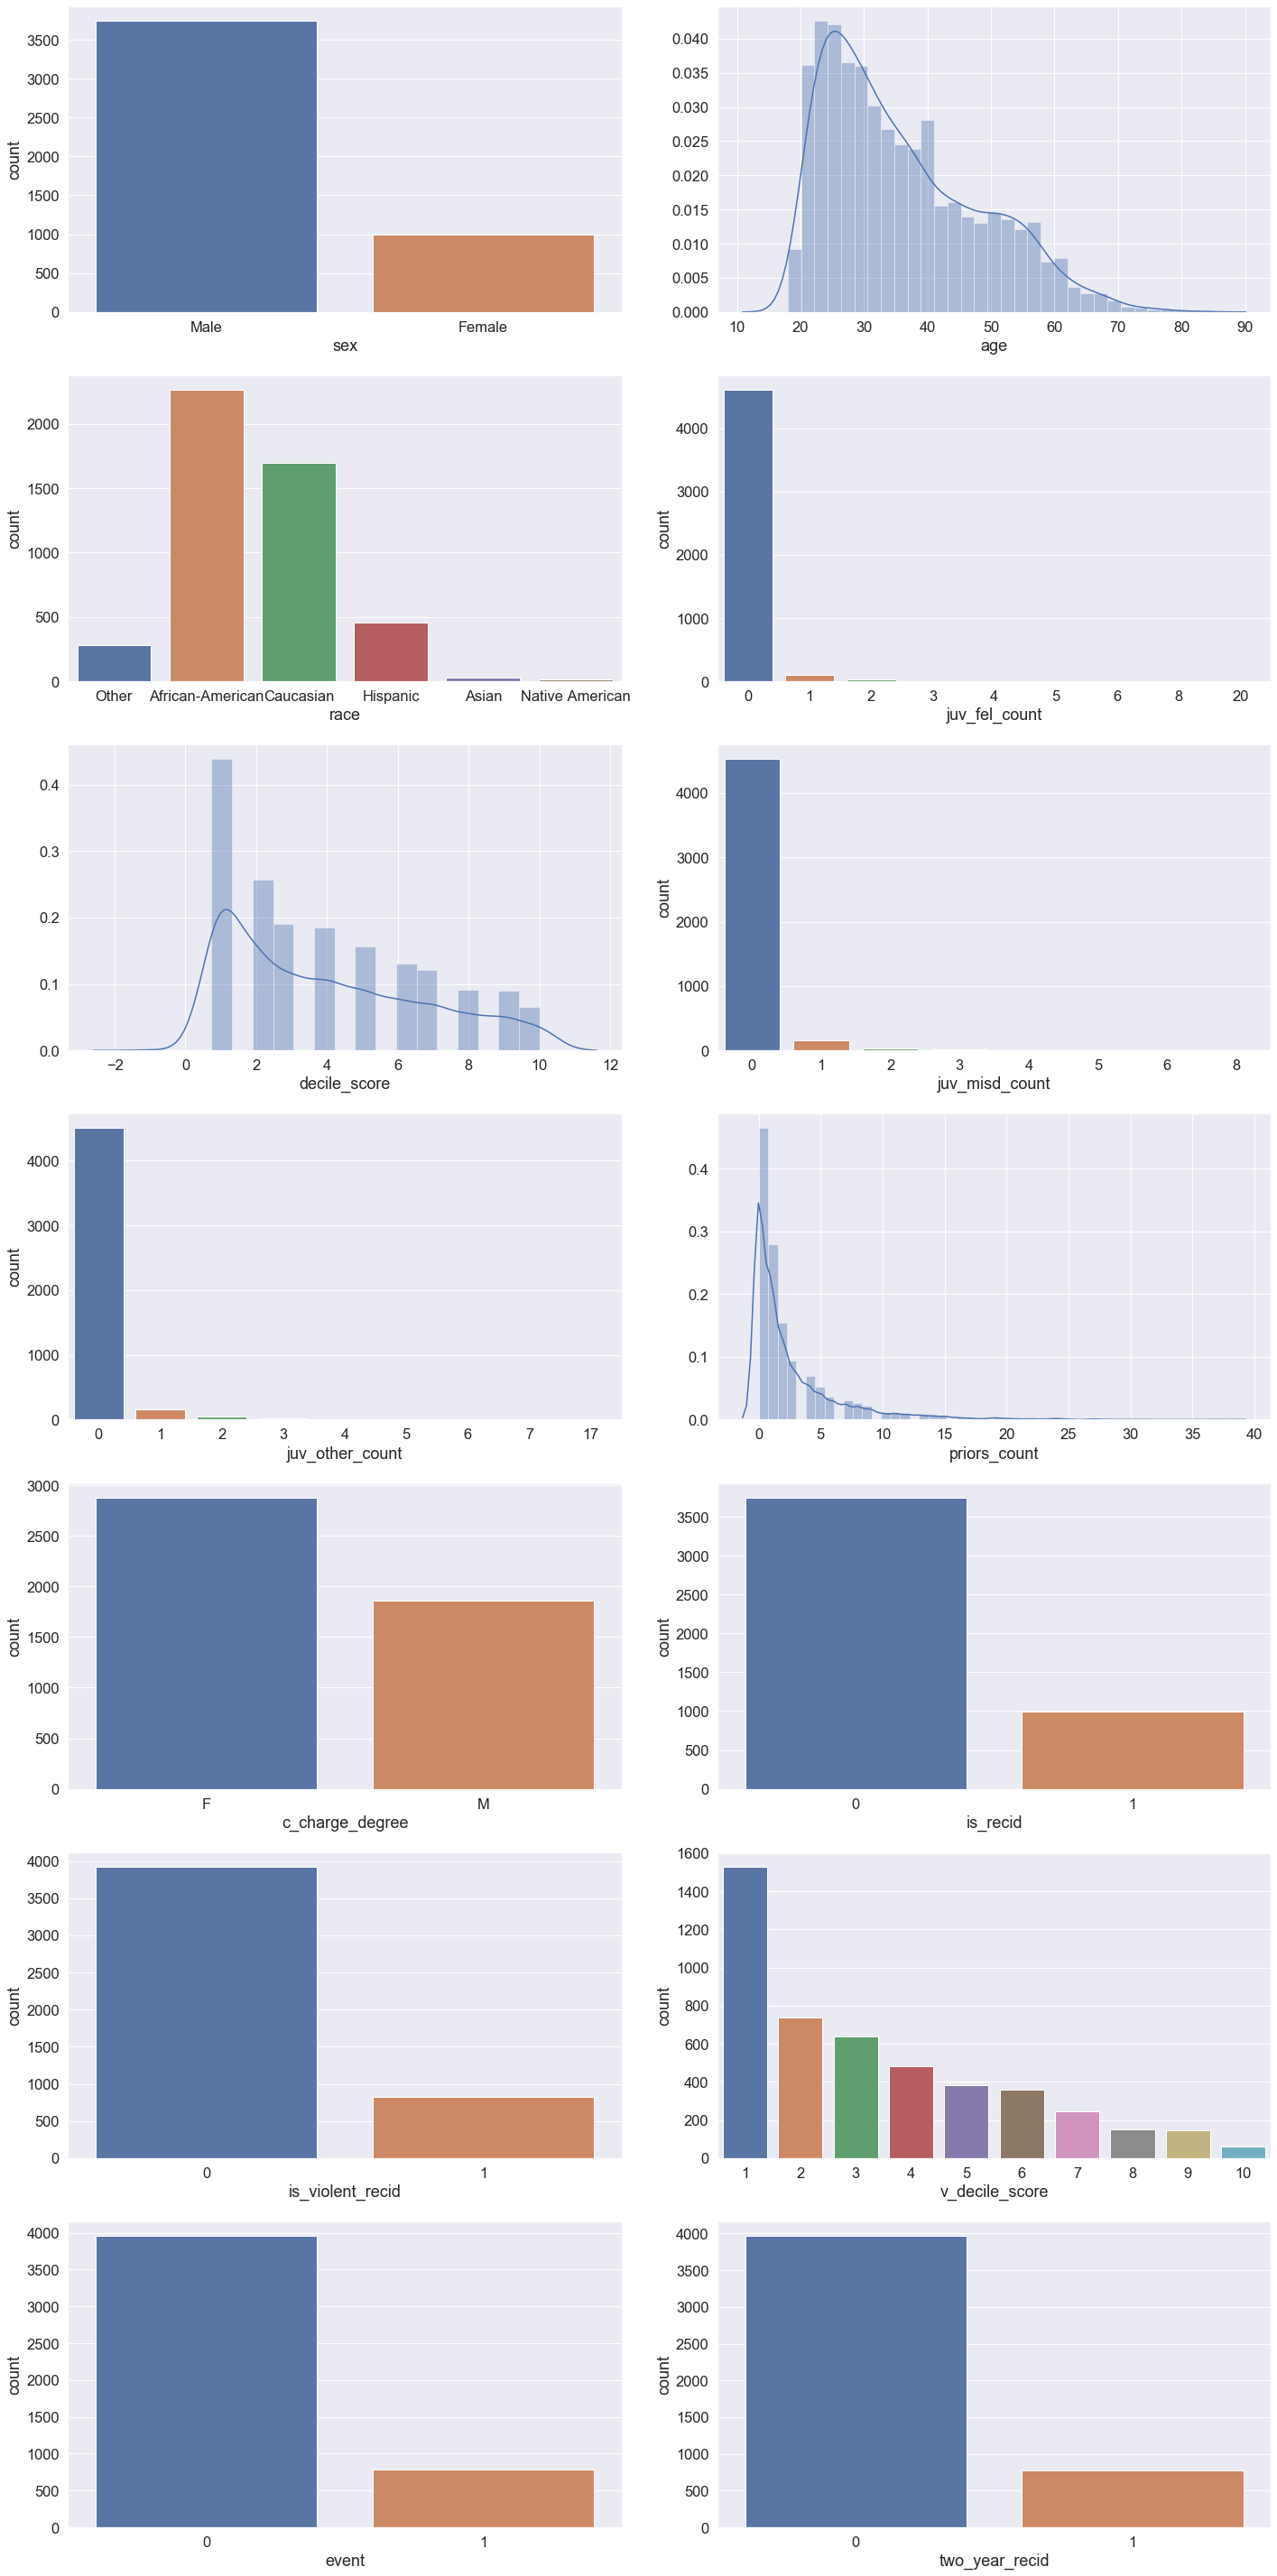

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.sex)
plt.subplot(7,2,2)
sns.distplot(df.age)
plt.subplot(7,2,3)
sns.countplot(df.race)
plt.subplot(7,2,4)
sns.countplot(df.juv_fel_count)
plt.subplot(7,2,5)
sns.distplot(df.decile_score)
plt.subplot(7,2,6)
sns.countplot(df.juv_misd_count)
plt.subplot(7,2,7)
sns.countplot(df.juv_other_count)
plt.subplot(7,2,8)
sns.distplot(df.priors_count)
plt.subplot(7,2,9)
sns.countplot(df.c_charge_degree)
plt.subplot(7,2,10)
sns.countplot(df.is_recid)
plt.subplot(7,2,11)
sns.countplot(df.is_violent_recid)
plt.subplot(7,2,12)
sns.countplot(df.v_decile_score)
plt.subplot(7,2,13)
sns.countplot(df.event)
plt.subplot(7,2,14)
sns.countplot(df.two_year_recid)

plt.tight_layout()
plt.show()

In [9]:
df['event'].value_counts()

0    3958
1     785
Name: event, dtype: int64

In [10]:
df['two_year_recid'].value_counts()

0    3968
1     775
Name: two_year_recid, dtype: int64

### Bivariate Data Exploration

Step Three: Explore Relationships Between the Data

Is there a significant discrepancy between the recidivism predicted of white defendants and other races?

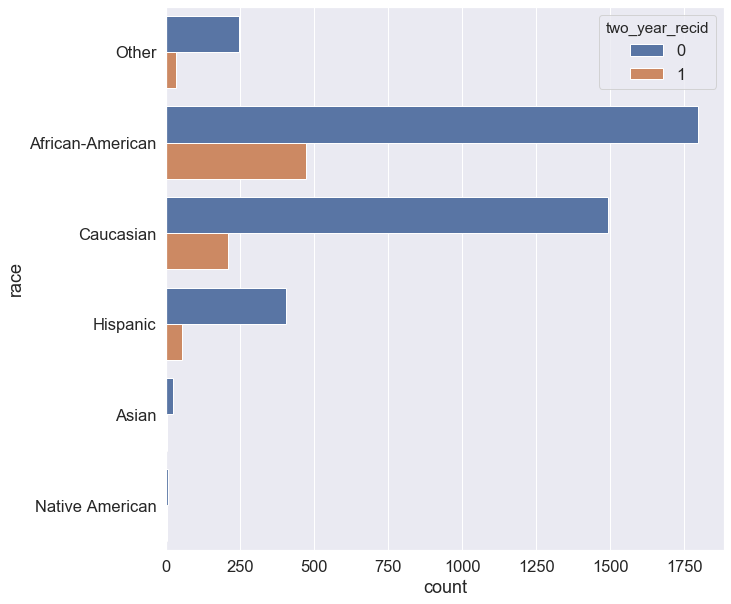

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(y=df['race'],hue=df['two_year_recid'],data=df);

Is there a strong relationship between prior arrests and the prediction of recidivism?

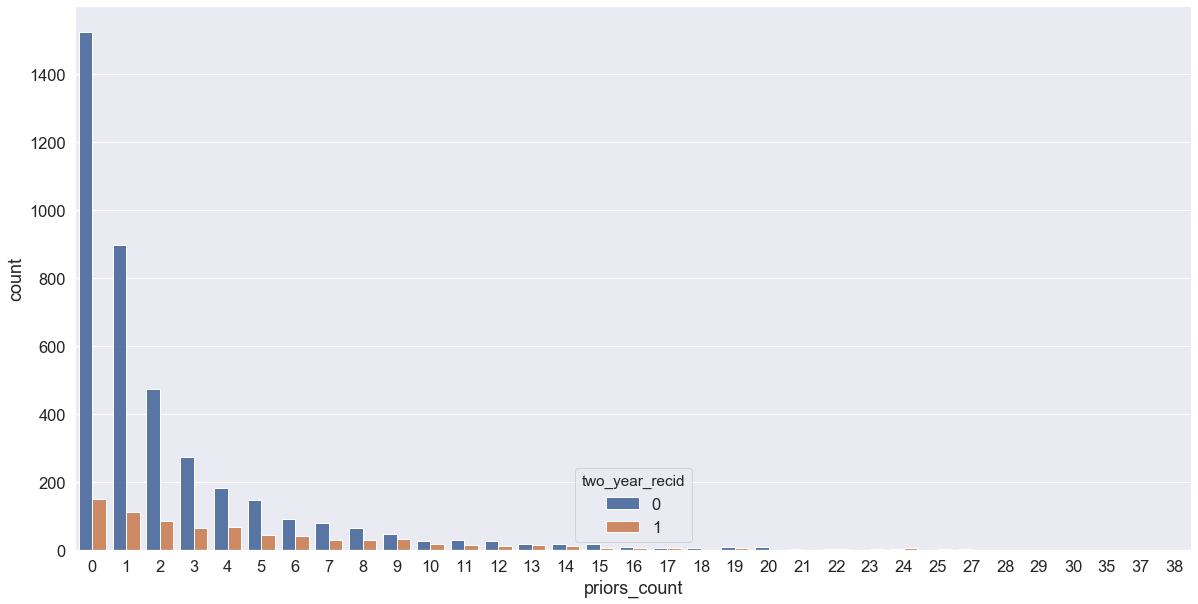

In [12]:
plt.figure(figsize=(20,10))
sns.countplot(df['priors_count'],hue=df['two_year_recid'],data=df);

In [13]:
df.corr()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,v_decile_score,start,end,event,two_year_recid
id,1.000000,-0.009392,-0.006055,-0.003953,0.001925,-0.002206,-0.009909,-0.008086,-0.006147,0.009985,-0.028361,NaN,0.002242,-0.004200,-0.006229,0.021426,-0.002600,-0.000636
age,-0.009392,1.000000,-0.054053,-0.411139,-0.124353,-0.133847,0.102593,-0.051142,0.084165,-0.174837,-0.027548,NaN,-0.165086,-0.584490,0.006137,0.171597,-0.151059,-0.164598
juv_fel_count,-0.006055,-0.054053,1.000000,0.158184,0.099687,0.035970,0.195438,-0.005967,0.007847,0.097124,-0.019868,NaN,0.103269,0.141338,0.014085,-0.078152,0.089574,0.096073
decile_score,-0.003953,-0.411139,0.158184,1.000000,0.238564,0.169882,0.428529,0.048255,0.051008,0.313179,-0.020897,NaN,0.315480,0.792744,0.147073,-0.317788,0.254669,0.314012
juv_misd_count,0.001925,-0.124353,0.099687,0.238564,1.000000,0.221379,0.275420,0.013989,0.014350,0.153671,-0.024064,NaN,0.159312,0.224853,0.012925,-0.118604,0.117892,0.156005
juv_other_count,-0.002206,-0.133847,0.035970,0.169882,0.221379,1.000000,0.097105,0.011085,0.013239,0.100150,-0.036326,NaN,0.100995,0.174898,-0.009959,-0.089540,0.074570,0.099052
priors_count,-0.009909,0.102593,0.195438,0.428529,0.275420,0.097105,1.000000,-0.007451,0.033551,0.243352,-0.048443,NaN,0.228158,0.228492,0.121303,-0.247549,0.183565,0.234191
days_b_screening_arrest,-0.008086,-0.051142,-0.005967,0.048255,0.013989,0.011085,-0.007451,1.000000,0.081808,0.087663,0.030270,NaN,0.035515,0.056358,-0.011327,-0.066321,0.078565,0.032666
c_days_from_compas,-0.006147,0.084165,0.007847,0.051008,0.014350,0.013239,0.033551,0.081808,1.000000,-0.038466,-0.021617,NaN,-0.033252,0.010746,-0.025198,0.027522,-0.027918,-0.029907
is_recid,0.009985,-0.174837,0.097124,0.313179,0.153671,0.100150,0.243352,0.087663,-0.038466,1.000000,NaN,NaN,0.886678,0.303744,0.063779,-0.577950,0.864341,0.857735


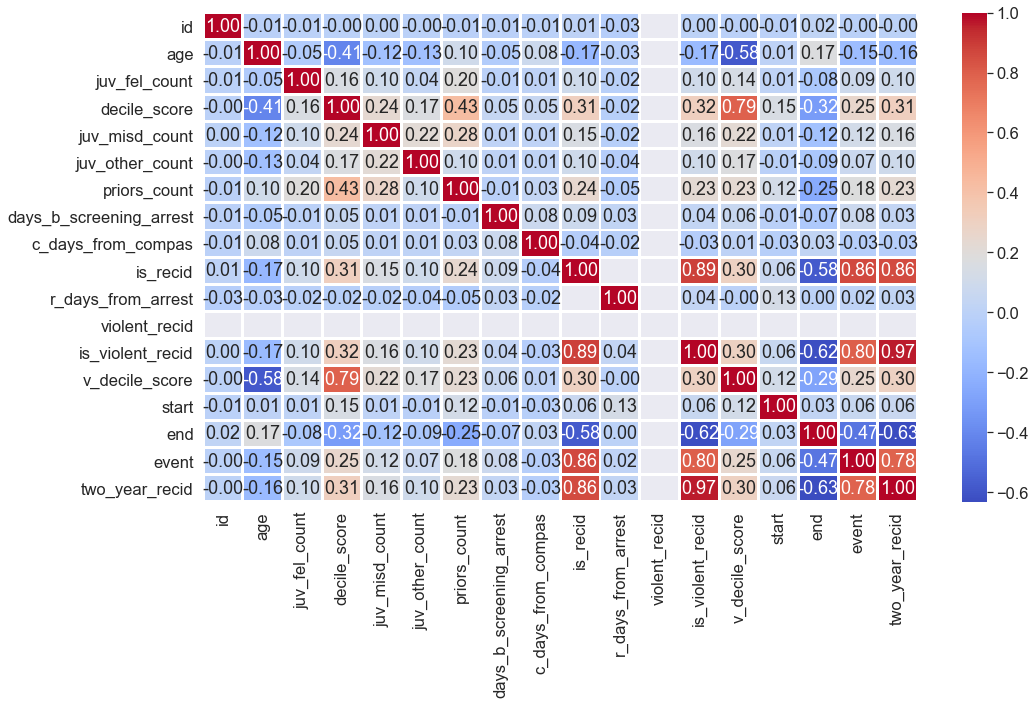

In [14]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

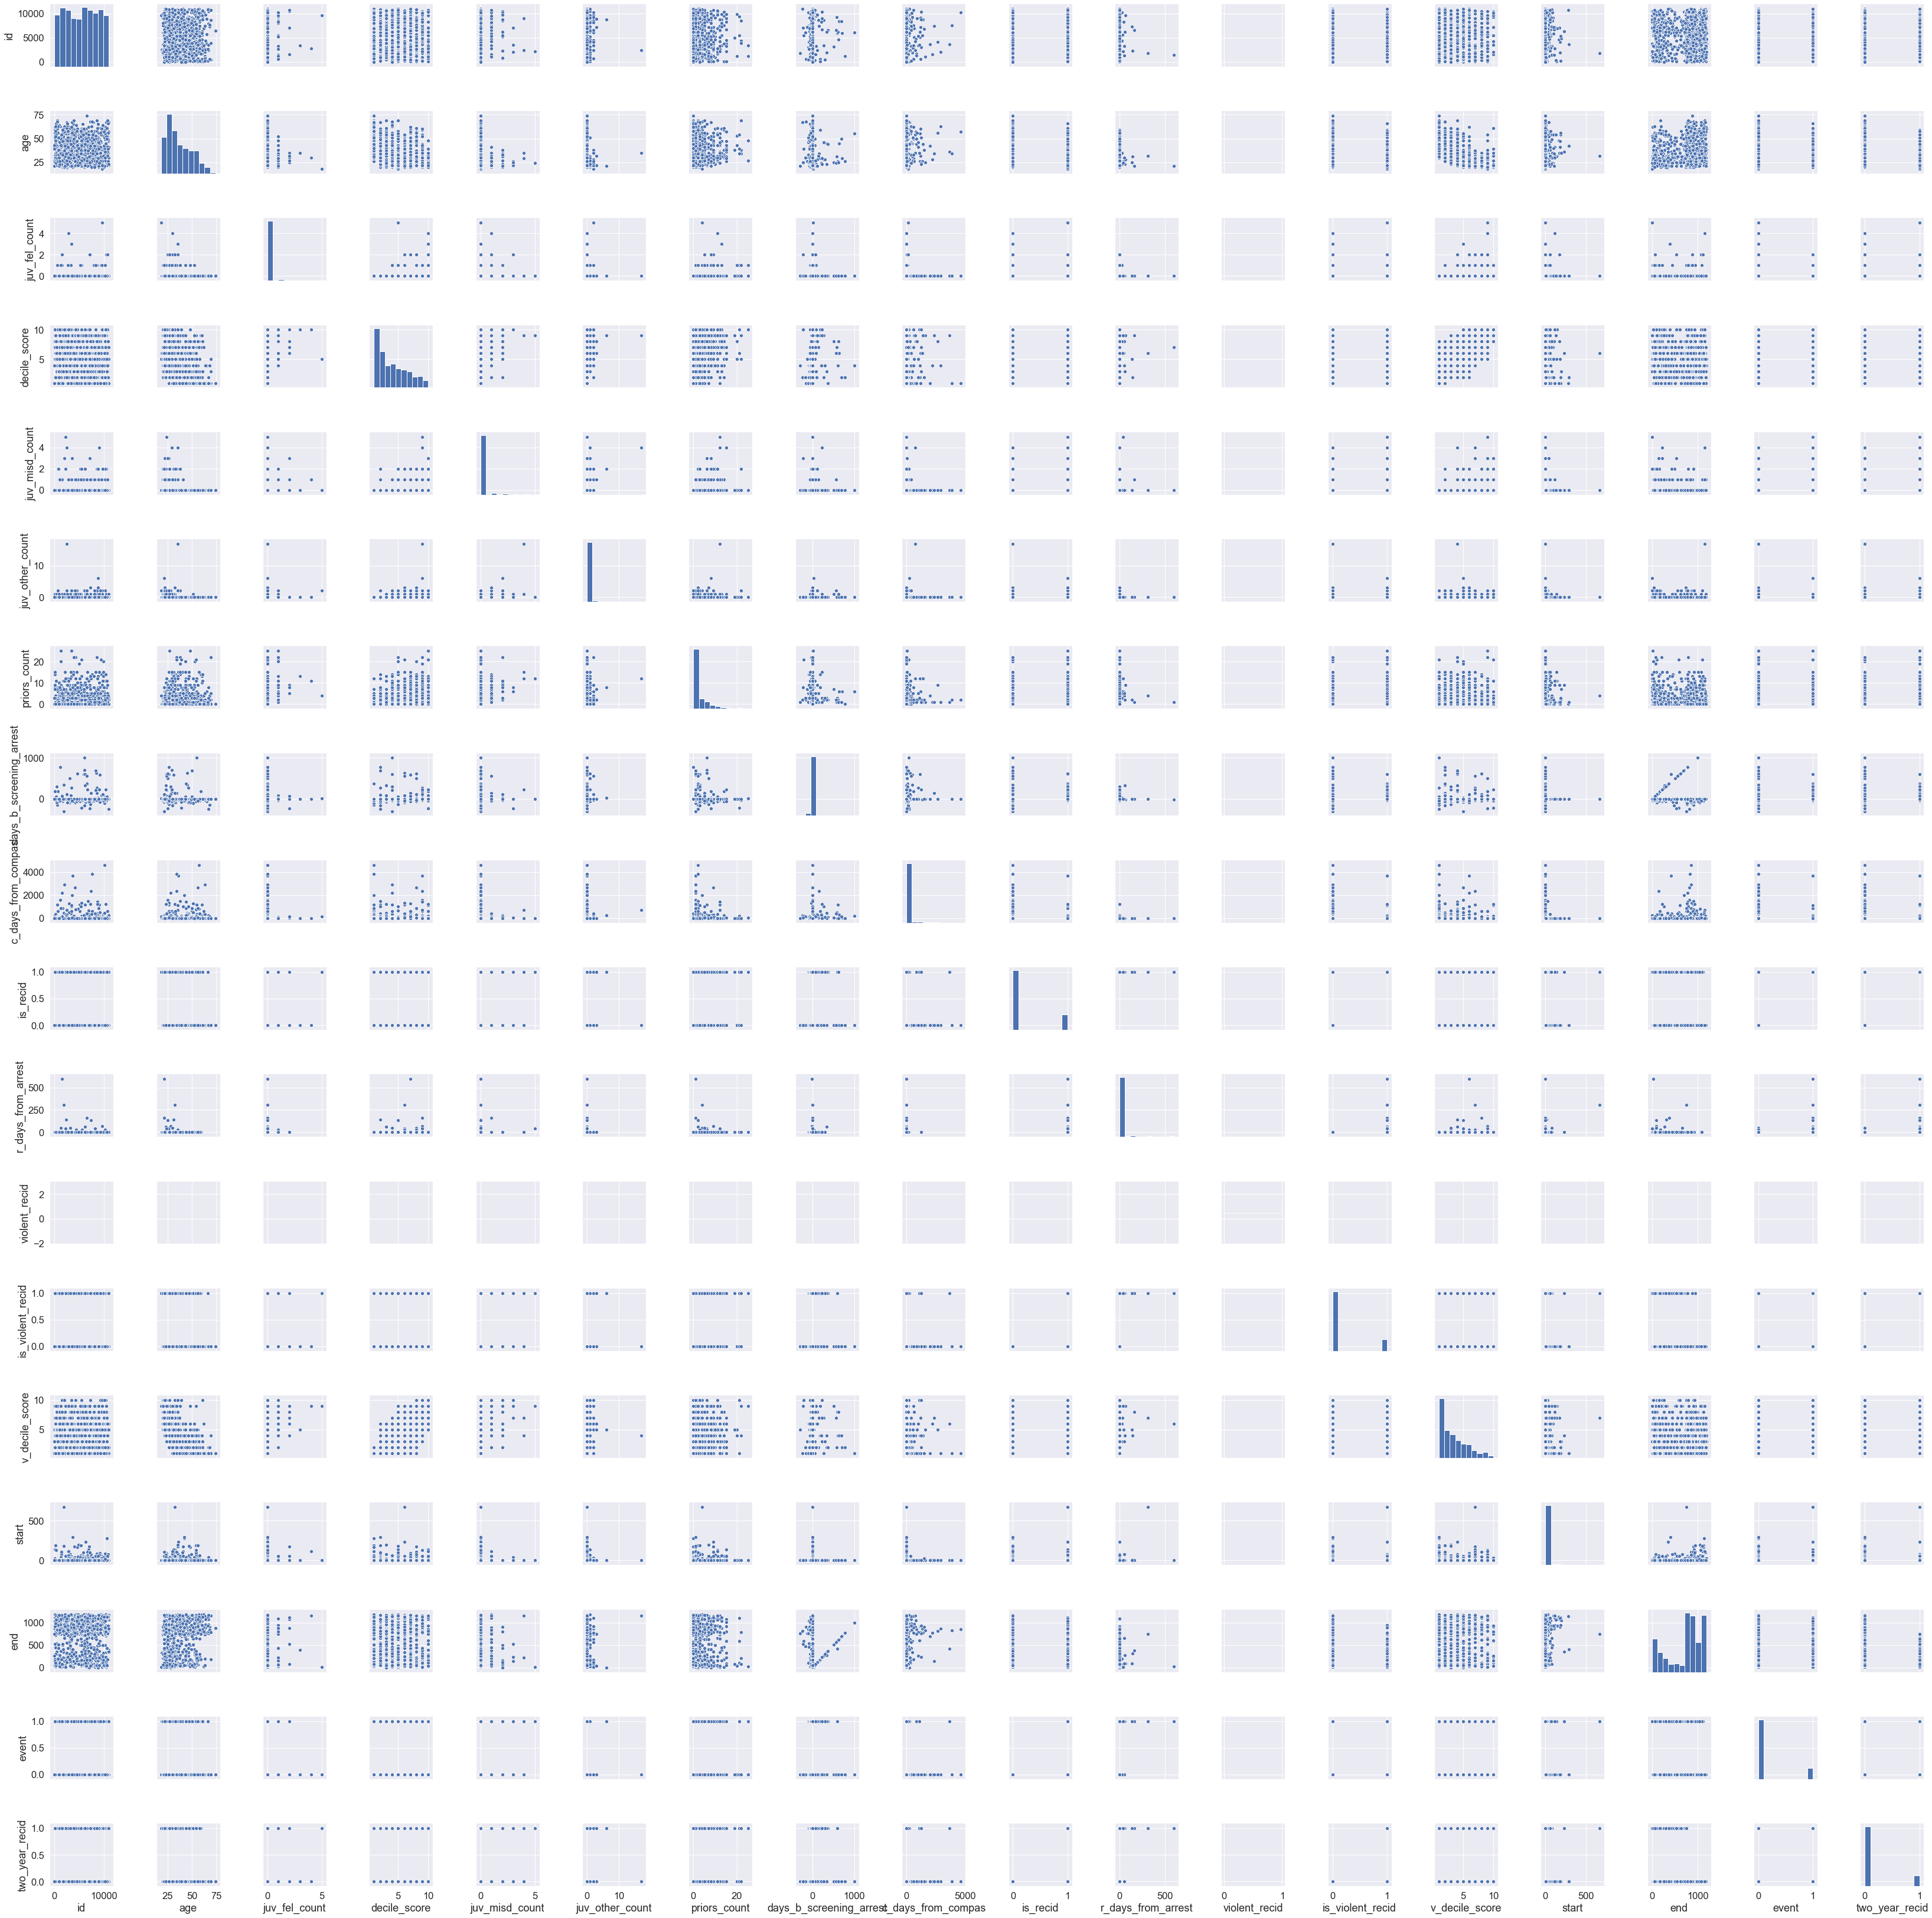

In [15]:
sns.pairplot(df.sample(1000))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [16]:
df.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     268
c_jail_in                   268
c_jail_out                  268
c_case_number                11
c_offense_date              771
c_arrest_date              3983
c_days_from_compas           11
c_charge_degree               0
c_charge_desc                17
is_recid                      0
r_case_number              3748
r_charge_degree            3748
r_days_from_arrest         4053
r_offense_date             3748
r_charge_desc              3771
r_jail_in                  4053
r_jail_o

In [17]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text',
       'screening_date', 'v_type_of_assessment', 'v_decile_score',
       'v_score_text', 'v_screening_date', 'in_custody', 'out_custody',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [18]:
df.drop(['days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number','c_offense_date', 
         'c_arrest_date', 'c_days_from_compas','c_charge_desc','r_case_number',
         'r_charge_degree', 'r_days_from_arrest', 'r_offense_date','r_charge_desc', 'r_jail_in', 
         'r_jail_out', 'violent_recid','vr_case_number', 'vr_charge_degree','vr_offense_date', 
         'vr_charge_desc','score_text','in_custody', 'out_custody'],axis=1,inplace=True)

In [19]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,is_violent_recid,type_of_assessment,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,F,0,0,Risk of Recidivism,14/8/2013,Risk of Violence,1,Low,14/8/2013,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,F,1,1,Risk of Recidivism,27/1/2013,Risk of Violence,1,Low,27/1/2013,9,159,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,F,0,0,Risk of Recidivism,13/1/2013,Risk of Violence,6,Medium,13/1/2013,0,1174,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,F,0,0,Risk of Recidivism,26/3/2013,Risk of Violence,1,Low,26/3/2013,0,1102,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,M,0,0,Risk of Recidivism,30/11/2013,Risk of Violence,1,Low,30/11/2013,1,853,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,0,9,0,0,0,F,0,0,Risk of Recidivism,20/10/2013,Risk of Violence,9,High,20/10/2013,0,169,0,0
4739,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,F,0,0,Risk of Recidivism,23/11/2013,Risk of Violence,5,Medium,23/11/2013,1,860,0,0
4740,10997,malcolm simmons,malcolm,simmons,2014-01-02,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,F,0,0,Risk of Recidivism,1/2/2014,Risk of Violence,5,Medium,1/2/2014,1,790,0,0
4741,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-01-10,57,Greater than 45,Other,0,1,0,0,0,F,0,0,Risk of Recidivism,14/1/2014,Risk of Violence,1,Low,14/1/2014,0,808,0,0


In [20]:
df.isnull().sum()

id                       0
name                     0
first                    0
last                     0
compas_screening_date    0
sex                      0
dob                      0
age                      0
age_cat                  0
race                     0
juv_fel_count            0
decile_score             0
juv_misd_count           0
juv_other_count          0
priors_count             0
c_charge_degree          0
is_recid                 0
is_violent_recid         0
type_of_assessment       0
screening_date           0
v_type_of_assessment     0
v_decile_score           0
v_score_text             0
v_screening_date         0
start                    0
end                      0
event                    0
two_year_recid           0
dtype: int64

### Treat Duplicate Values

In [21]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [22]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree',
       'is_recid', 'is_violent_recid', 'type_of_assessment', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [23]:
#Drop Text and Dates columns
df.drop(['id', 'name', 'first', 'last','compas_screening_date','dob','age_cat','type_of_assessment', 
         'screening_date','v_type_of_assessment','v_score_text','v_screening_date', 'start', 
         'end'],axis=1,inplace=True)

In [24]:
df

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,69,Other,0,1,0,0,0,F,0,0,1,0,0
1,Male,34,African-American,0,3,0,0,0,F,1,1,1,1,1
2,Male,23,African-American,0,8,1,0,1,F,0,0,6,0,0
3,Male,43,Other,0,1,0,0,2,F,0,0,1,0,0
4,Male,44,Other,0,1,0,0,0,M,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,Male,20,African-American,0,9,0,0,0,F,0,0,9,0,0
4739,Male,23,African-American,0,7,0,0,0,F,0,0,5,0,0
4740,Male,23,African-American,0,3,0,0,0,F,0,0,5,0,0
4741,Male,57,Other,0,1,0,0,0,F,0,0,1,0,0


### Treat Data Types

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sex               4743 non-null   object
 1   age               4743 non-null   int64 
 2   race              4743 non-null   object
 3   juv_fel_count     4743 non-null   int64 
 4   decile_score      4743 non-null   int64 
 5   juv_misd_count    4743 non-null   int64 
 6   juv_other_count   4743 non-null   int64 
 7   priors_count      4743 non-null   int64 
 8   c_charge_degree   4743 non-null   object
 9   is_recid          4743 non-null   int64 
 10  is_violent_recid  4743 non-null   int64 
 11  v_decile_score    4743 non-null   int64 
 12  event             4743 non-null   int64 
 13  two_year_recid    4743 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 518.9+ KB


In [26]:
df2 = pd.get_dummies(df,columns=['sex','race','c_charge_degree'],drop_first=True)

In [27]:
df2

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,event,two_year_recid,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M
0,69,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,34,0,3,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0
2,23,0,8,1,0,1,0,0,6,0,0,1,0,0,0,0,0,0
3,43,0,1,0,0,2,0,0,1,0,0,1,0,0,0,0,1,0
4,44,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,20,0,9,0,0,0,0,0,9,0,0,1,0,0,0,0,0,0
4739,23,0,7,0,0,0,0,0,5,0,0,1,0,0,0,0,0,0
4740,23,0,3,0,0,0,0,0,5,0,0,1,0,0,0,0,0,0
4741,57,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


### Create and save processed dataset

In [28]:
df2.columns

Index(['age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'is_recid', 'is_violent_recid',
       'v_decile_score', 'event', 'two_year_recid', 'sex_Male', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_M'],
      dtype='object')

In [29]:
df2 = df2[['age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'is_recid', 'is_violent_recid',
       'v_decile_score', 'event', 'sex_Male', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_M','two_year_recid']]

In [30]:
df2

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,event,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M,two_year_recid
0,69,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
1,34,0,3,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1
2,23,0,8,1,0,1,0,0,6,0,1,0,0,0,0,0,0,0
3,43,0,1,0,0,2,0,0,1,0,1,0,0,0,0,1,0,0
4,44,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,20,0,9,0,0,0,0,0,9,0,1,0,0,0,0,0,0,0
4739,23,0,7,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0
4740,23,0,3,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0
4741,57,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [31]:
#df2.to_csv("recidtrain.csv",index=False)

### Train Test Split

In [32]:
df2.shape

(4743, 18)

In [33]:
X = df2.iloc[:,0:17]
y = df2.iloc[:,17]

### Treat Imbalance Data

In [34]:
y.value_counts()

0    3968
1     775
Name: two_year_recid, dtype: int64

In [35]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [36]:
new_X, new_y = ros.fit_resample(X, y)

In [37]:
new_y.value_counts()

1    3968
0    3968
Name: two_year_recid, dtype: int64

In [38]:
new_X

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,event,sex_Male,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M
0,69,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
1,34,0,3,0,0,0,1,1,1,1,1,0,0,0,0,0,0
2,23,0,8,1,0,1,0,0,6,0,1,0,0,0,0,0,0
3,43,0,1,0,0,2,0,0,1,0,1,0,0,0,0,1,0
4,44,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,25,0,5,0,0,4,1,1,4,1,1,0,0,0,0,0,0
7932,23,0,8,0,0,0,1,1,9,1,1,0,1,0,0,0,1
7933,36,0,7,0,0,0,1,1,2,1,1,0,0,0,0,0,1
7934,21,0,9,2,1,2,1,1,8,1,1,0,1,0,0,0,0


In [39]:
new_X.values, new_y.values

(array([[69,  0,  1, ...,  0,  1,  0],
        [34,  0,  3, ...,  0,  0,  0],
        [23,  0,  8, ...,  0,  0,  0],
        ...,
        [36,  0,  7, ...,  0,  0,  1],
        [21,  0,  9, ...,  0,  0,  0],
        [27,  0,  9, ...,  0,  0,  0]], dtype=int64),
 array([0, 1, 0, ..., 1, 1, 1], dtype=int64))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6348, 17), (1588, 17), (6348,), (1588,))

### Feature Scaling

In [42]:
X_train

array([[26,  0,  8, ...,  0,  0,  0],
       [26,  0, 10, ...,  0,  0,  1],
       [21,  0,  8, ...,  0,  0,  0],
       ...,
       [53,  0,  1, ...,  0,  0,  1],
       [51,  0,  1, ...,  0,  0,  1],
       [27,  0,  4, ...,  0,  0,  0]], dtype=int64)

In [43]:
minmax = MinMaxScaler()

In [44]:
X_train_scaled = minmax.fit_transform(X_train)

In [45]:
X_test_scaled = minmax.transform(X_test)

In [46]:
X_train_scaled

array([[0.12307692, 0.        , 0.81818182, ..., 0.        , 0.        ,
        0.        ],
       [0.12307692, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.04615385, 0.        , 0.81818182, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.53846154, 0.        , 0.18181818, ..., 0.        , 0.        ,
        1.        ],
       [0.50769231, 0.        , 0.18181818, ..., 0.        , 0.        ,
        1.        ],
       [0.13846154, 0.        , 0.45454545, ..., 0.        , 0.        ,
        0.        ]])

In [47]:
X_test_scaled

array([[0.06153846, 0.        , 0.81818182, ..., 0.        , 0.        ,
        0.        ],
       [0.52307692, 0.        , 0.18181818, ..., 0.        , 0.        ,
        0.        ],
       [0.36923077, 0.        , 0.27272727, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.29230769, 0.        , 0.45454545, ..., 0.        , 0.        ,
        1.        ],
       [0.10769231, 0.        , 0.45454545, ..., 0.        , 0.        ,
        0.        ],
       [0.23076923, 0.        , 0.18181818, ..., 0.        , 0.        ,
        0.        ]])

### Model Training

### Using XGBoost (Scikit-Learn)

In [48]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [49]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.006297
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.006297
[2]	validation_0-error:0.006297
[3]	validation_0-error:0.006297
[4]	validation_0-error:0.006297
[5]	validation_0-error:0.006297
[6]	validation_0-error:0.006297
[7]	validation_0-error:0.006297
[8]	validation_0-error:0.006297
[9]	validation_0-error:0.006297
[10]	validation_0-error:0.006297
Stopping. Best iteration:
[0]	validation_0-error:0.006297



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [50]:
y_pred = xgbmodel.predict(X_test_scaled)

In [51]:
y_pred

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

### Model Evaluation

In [52]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[784,  10],
       [  0, 794]], dtype=int64)

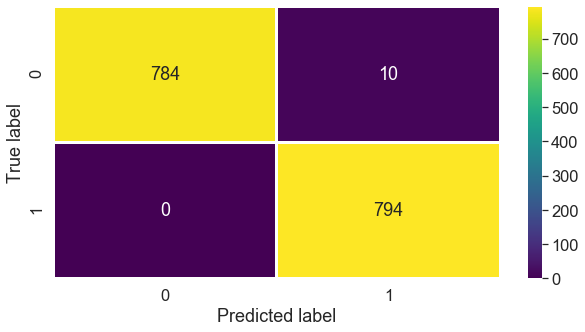

In [53]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

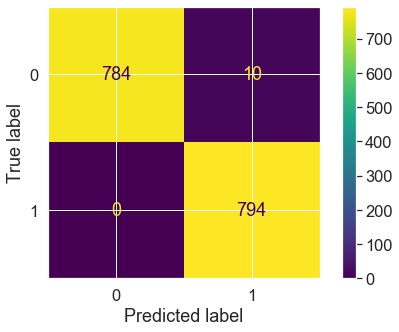

In [54]:
fig , ax = plt.subplots(figsize=(8,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       794
           1       0.99      1.00      0.99       794

    accuracy                           0.99      1588
   macro avg       0.99      0.99      0.99      1588
weighted avg       0.99      0.99      0.99      1588



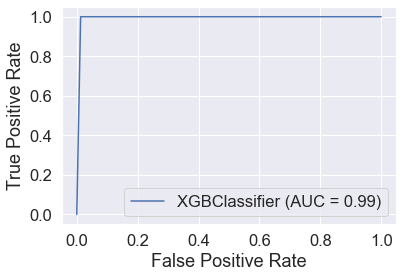

In [56]:
plot_roc_curve(xgbmodel,X_test_scaled,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [57]:
X.columns

Index(['age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'is_recid', 'is_violent_recid',
       'v_decile_score', 'event', 'sex_Male', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_M'],
      dtype='object')

In [58]:
xgbmodel.get_booster().feature_names = ['age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'is_recid', 'is_violent_recid',
       'v_decile_score', 'event', 'sex_Male', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_M']

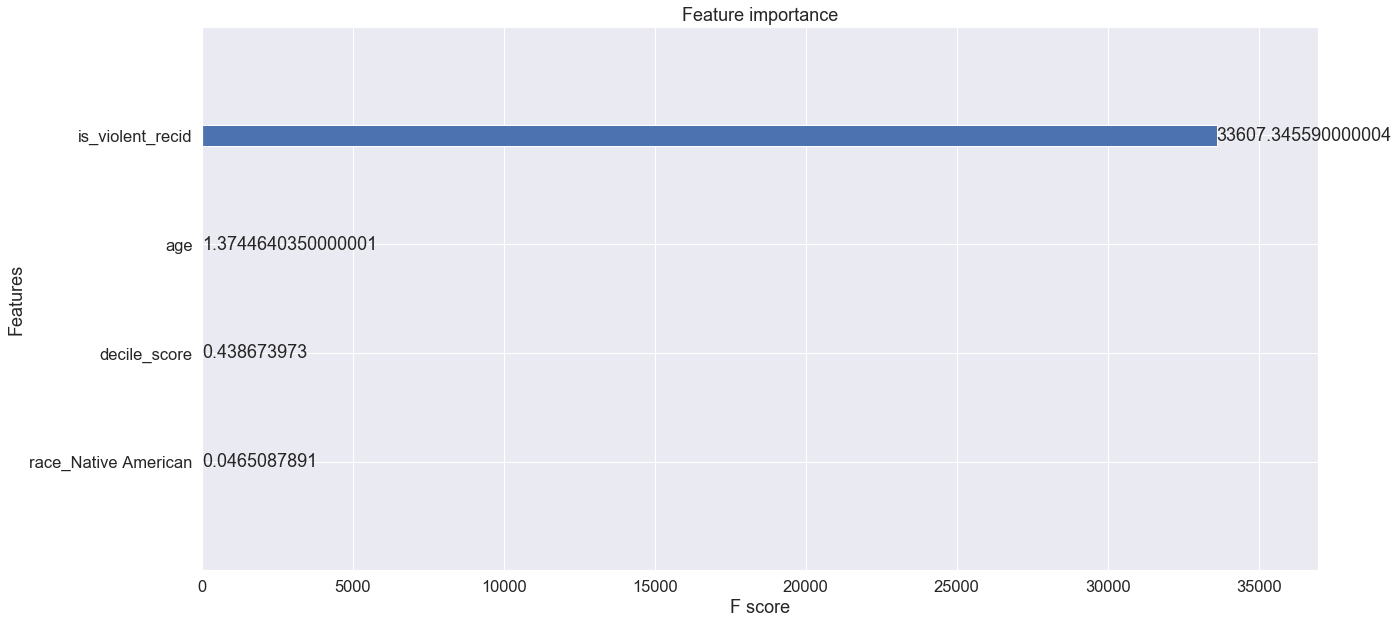

In [59]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax, importance_type='total_gain')
plt.show()

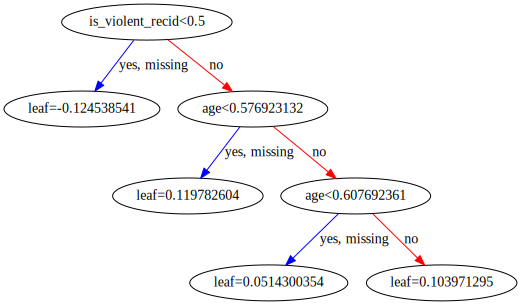

In [60]:
xgb.to_graphviz(xgbmodel,num_trees=9)

### Cross-Validation

In [61]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [62]:
cv.mean()

0.9907224126662311

### Save the Model

In [63]:
filename = 'modelrecid.sav'
dump(xgbmodel,open(filename,'wb'))